# Predicting Layoffs

---
author: Laura Rosok
date: October 11, 2024
embed-resources: true
---

## Introduction

This model aims to predict the number of layoffs that may occur within a company by analyzing various factors, including location, industry type, date of layoff, funding stage, and total funds raised.

The model was developed using a comprehensive dataset comprising 2,257 tech companies that experienced layoffs from COVID 2019 to 2024. This dataset, sourced from Kaggle, provides valuable insights into layoff trends and factors influencing workforce reductions.

You can access the dataset [here](https://www.kaggle.com/datasets/swaptr/layoffs-2022).

## Methods

In [40]:
# Imports

# Data manipulation
import pandas as pd
import numpy as np
import os

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Lasso, LinearRegression, ElasticNet, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Kaggle utilities
import kagglehub

### Data

In [41]:
# load data
path = kagglehub.dataset_download("swaptr/layoffs-2022")
csv_file = next(file for file in os.listdir(path) if file.endswith('.csv'))
data = pd.read_csv(os.path.join(path, csv_file), parse_dates=['date'])

### Data Dictionary

#### Target Variable
- **`total_laid_off`** (`float64`): 
  - The total number of employees laid off by the company.

#### Feature Variables
1. **`location`** (`object`): 
   - The geographical location of the company's headquarters.
   
2. **`industry`** (`object`): 
   - The specific industry in which the company operates.
   
3. **`year`** (`int32`): 
   - The year during which the layoff occurred.
   
4. **`month`** (`int32`): 
   - The month during which the layoff occurred.
   
5. **`stage`** (`object`): 
   - The current stage of funding for the company.
   
6. **`country`** (`object`): 
   - The country where the company is based.
   
7. **`funds_raised`** (`float64`): 
   - The amount of funds raised by the company, measured in millions of dollars.


### Data Cleaning

In [42]:
# drop unnecessary or repetitive columns
data = data.drop(['percentage_laid_off'], axis=1)

# Extract year and month from date
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month

# Drop duplicated rows
data.drop_duplicates(inplace = True)

# Check for outliers using IQR method and replace them with the median
numeric_columns = ['total_laid_off', 'funds_raised', 'year', 'month']

for col in numeric_columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    median = data[col].median()
    data[col] = np.where((data[col] < lower_bound) | (data[col] > upper_bound), median, data[col])

In [43]:
# drop null values if >=20% of column is missing

for column in data.columns:
    missing_percentage = (data[column].isnull().sum()) / len(data) * 100 
    if missing_percentage >= 20:  
        print(f"{column} should drop null values (missing: {missing_percentage:.2f}%)")


data.dropna(subset=['total_laid_off'], inplace=True)

# impute null values if <20% of column is missing

numeric_features = data.select_dtypes(['int', 'float']).columns.tolist()
numeric_imputer = SimpleImputer(strategy='median')
data[numeric_features] = numeric_imputer.fit_transform(data[numeric_features])

categorical_features = data.select_dtypes(['category', 'object']).columns.tolist()
categorical_imputer = SimpleImputer(strategy='most_frequent')
data[categorical_features] = categorical_imputer.fit_transform(data[categorical_features])


total_laid_off should drop null values (missing: 34.83%)


In [44]:
# check for normality of target variable

In [45]:
# | echo: false

# Summary Statistics for Numeric Features
numeric_stats = data.describe(include='number').transpose()
numeric_stats['missing_percentage'] = (data.isnull().sum() / len(data)) * 100

# Rename columns and round numeric stats
numeric_stats = numeric_stats.rename(columns={
    'count': 'Count', 'mean': 'Mean', 'std': 'Standard Deviation',
    'min': 'Min', '25%': '25th Percentile', '50%': 'Median',
    '75%': '75th Percentile', 'max': 'Max'
}).round(2)

# Format dictionary for numeric statistics
format_dict = {col: '{:.2f}' for col in numeric_stats.columns if col != 'Count'}
format_dict.update({'Count': '{:.0f}', 'missing_percentage': '{:.2f}%'})

# Styled Table for Numeric Statistics
styled_numeric_stats = numeric_stats.style \
    .set_table_attributes('style="width: 100%; border-collapse: collapse;"') \
    .set_caption("Summary Statistics for Numeric Features") \
    .format(format_dict) \
    .highlight_null(color='lightgray')

# Summary Statistics for Categorical Features
categorical_stats = data.describe(include='object').transpose()
categorical_stats['missing_percentage'] = (data.isnull().sum() / len(data)) * 100
categorical_stats = categorical_stats.rename(columns={
    'count': 'Count', 'unique': 'Unique Values', 'top': 'Most Frequent', 'freq': 'Frequency'
})

# Styled Table for Categorical Statistics
styled_categorical_stats = categorical_stats.style \
    .set_table_attributes('style="width: 100%; border-collapse: collapse;"') \
    .set_caption("Summary Statistics for Categorical Features") \
    .format({'missing_percentage': "{:.2f}%"}) \
    .highlight_null(color='lightgray')

# Display both styled tables
display(styled_numeric_stats, styled_categorical_stats)


,Count,Mean,Standard Deviation,Min,25th Percentile,Median,75th Percentile,Max,missing_percentage
total_laid_off,2509,99.08,86.20,3.00,40.00,81.00,120.00,424.00,0.00%
funds_raised,2509,224.18,226.18,0.00,71.00,167.00,278.00,1100.00,0.00%
year,2509,2022.78,0.68,2021.00,2022.00,2023.00,2023.00,2024.00,0.00%
month,2509,5.82,3.23,1.00,3.00,6.00,8.00,12.00,0.00%


,Count,Unique Values,Most Frequent,Frequency,missing_percentage
company,2509,1844,Amazon,8,0.00%
location,2509,190,SF Bay Area,640,0.00%
industry,2509,30,Finance,314,0.00%
stage,2509,16,Post-IPO,583,0.00%
country,2509,53,United States,1584,0.00%


The tables above provide a detailed summary of numeric and categorical features in the dataset.

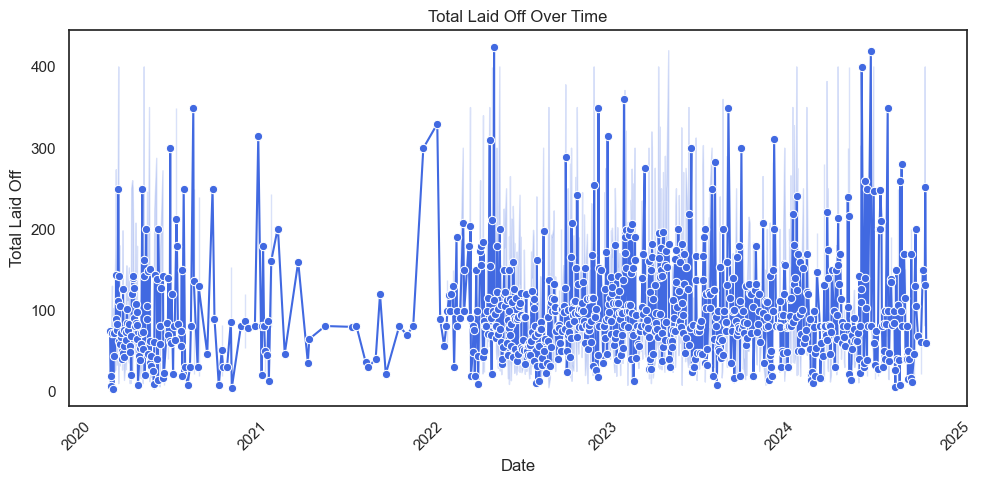

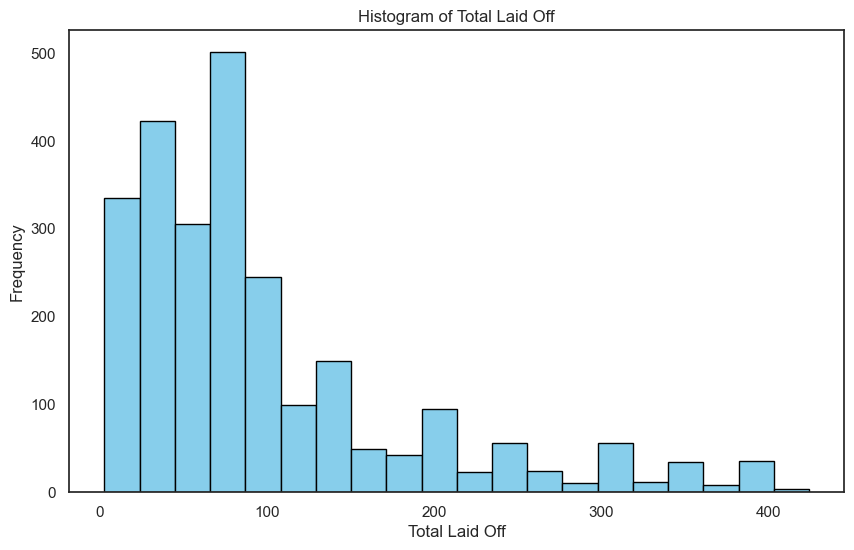

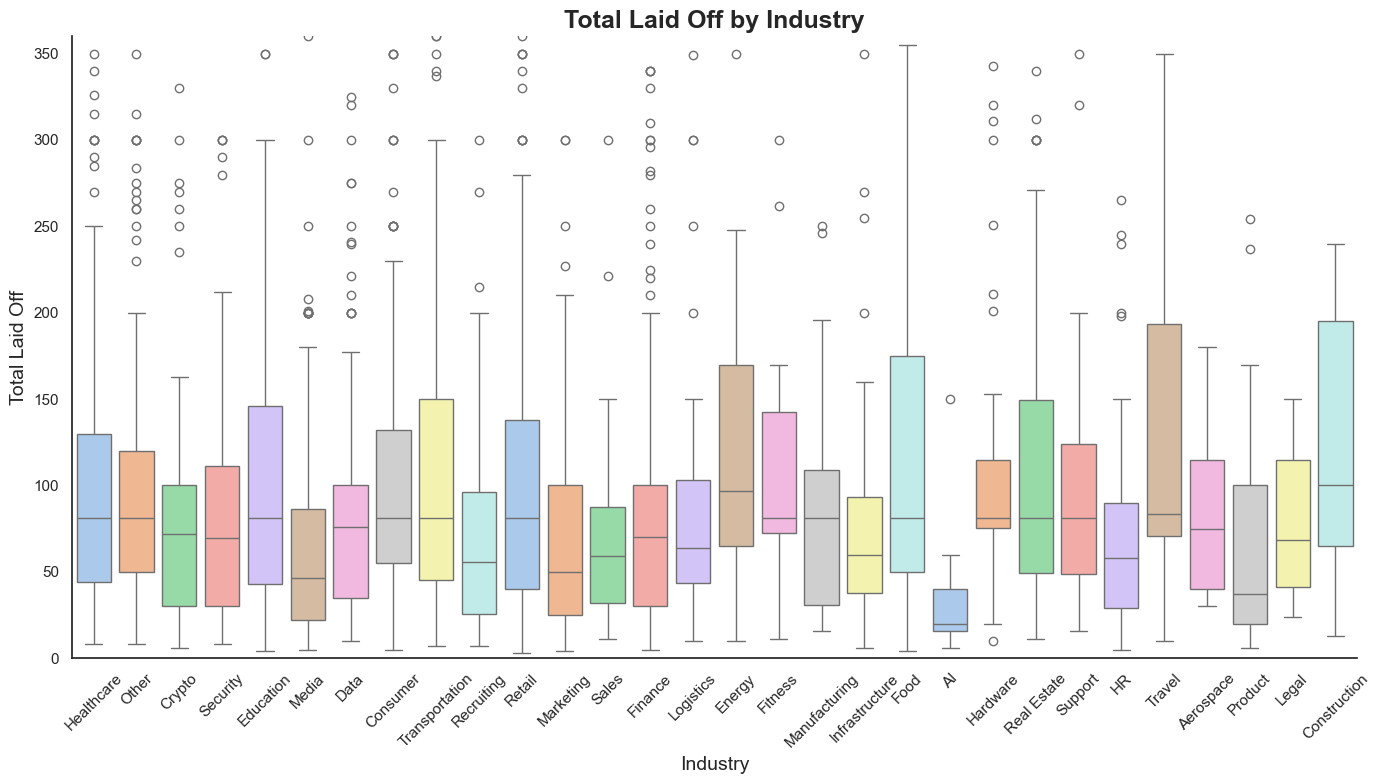

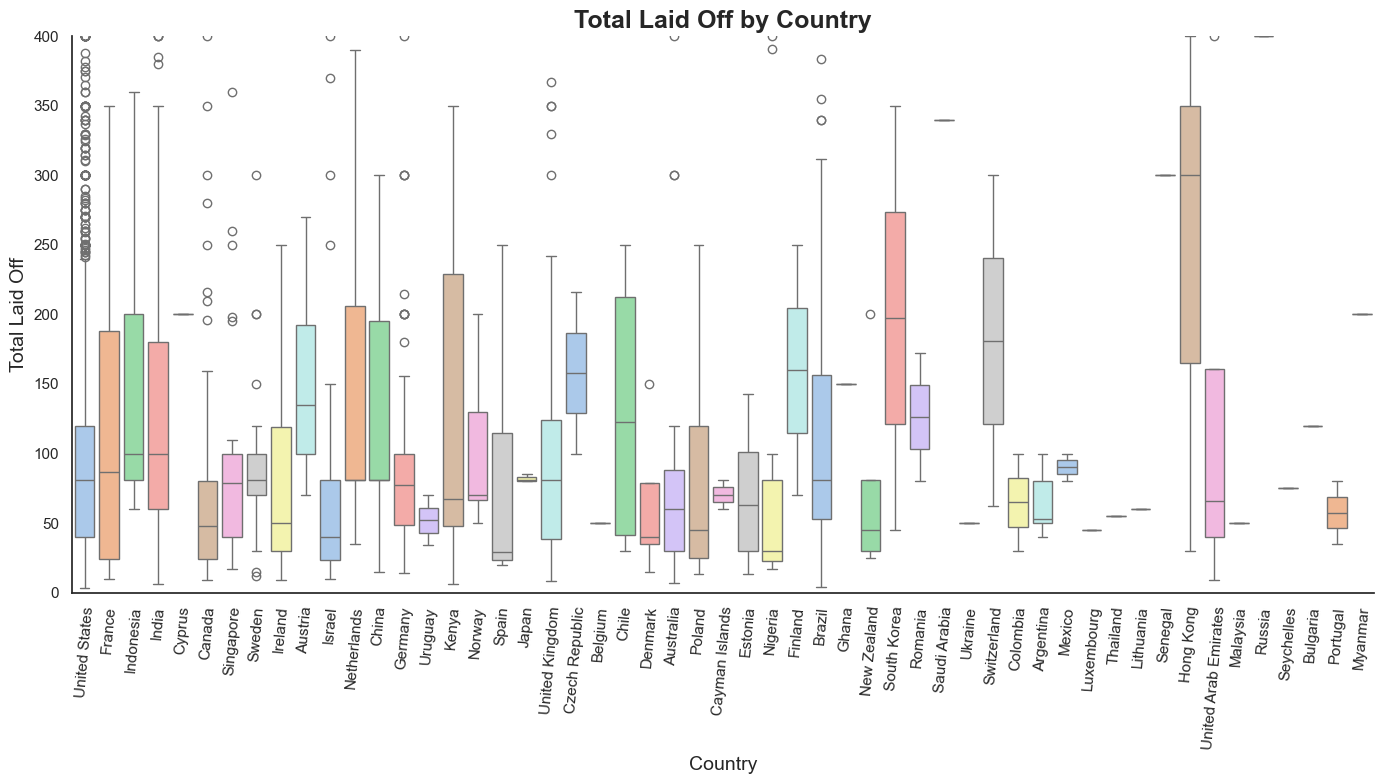

In [46]:
# | echo: false

# import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='white')

# Line Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x='date', y='total_laid_off', data=data, color='royalblue', marker='o')
plt.xlabel('Date')
plt.ylabel('Total Laid Off')
plt.title('Total Laid Off Over Time')
plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()

# Histogram of Total Laid Off
plt.figure(figsize=(10, 6))
plt.hist(data['total_laid_off'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Total Laid Off')
plt.ylabel('Frequency')
plt.title('Histogram of Total Laid Off')
plt.show()

# Box Plot for total_laid_off by industry
plt.figure(figsize=(14, 8))
sns.boxplot(x='industry', y='total_laid_off', data=data, hue='industry', palette='pastel', legend=False)
plt.xticks(rotation=45)
plt.title('Total Laid Off by Industry', fontsize=18, fontweight='bold')
plt.ylabel('Total Laid Off', fontsize=14)
plt.xlabel('Industry', fontsize=14)
plt.grid(False) 
sns.despine() 
plt.ylim(0, data['total_laid_off'].quantile(.98)) 
plt.tight_layout()
plt.show()

# Box Plot for total_laid_off by country
plt.figure(figsize=(14, 8))
sns.boxplot(x='country', y='total_laid_off', data=data, hue='country', palette='pastel', legend=False)
plt.xticks(rotation=85)
plt.title('Total Laid Off by Country', fontsize=18, fontweight='bold')
plt.ylabel('Total Laid Off', fontsize=14)
plt.xlabel('Country', fontsize=14)
plt.grid(False) 
sns.despine() 
plt.ylim(0, data['total_laid_off'].quantile(.99)) 
plt.tight_layout()
plt.show()


The figures above illustrate the following:

1. **Fluctuations in Layoffs**: Total number of people laid off over time.
2. **Distribution of Layoffs**: A histogram of total layoffs indicates a left-skewed distribution.
3. **Industry Analysis**: Total number of layoffs categorized by industry type.
4. **Geographical Distribution**: Total layoffs by country.


### Models

In [47]:
# process data for ML

# based on feature importance, drop unnecessary or repetitive columns
data['month_year'] = data['date'].dt.to_period('M').astype('object')
data = data.drop(['date', 'year', 'month'], axis=1)

# log transform target due to left-skew
data['total_laid_off'] = np.log1p(data['total_laid_off'])


X = data.drop('total_laid_off', axis=1)
y = data['total_laid_off']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [48]:
# Identify numeric and categorical features
numeric_features = X_train.select_dtypes(['int', 'float']).columns.tolist()
cat_features = X_train.select_dtypes(['category', 'object']).columns.tolist()

# Pipeline for numeric features
Numeric_pipeline = Pipeline(steps=[
    ('Standardize', StandardScaler())
])

# Pipeline for categorical features
Categorical_pipeline = Pipeline(steps=[
    ('OneHotEncoder', OneHotEncoder(handle_unknown='infrequent_if_exist', max_categories=5))
])

# Column transformer
preprocessor = ColumnTransformer(transformers=[
    ('Numeric_processing', Numeric_pipeline, numeric_features),
    ('Categorical_processing', Categorical_pipeline, cat_features)
])

# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DummyRegressor())  
])

# Baseline pipeline 
baseline_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())  
])


In [49]:
# Create dummy param grid for baseline testing
baseline_param_grid = {}

# Create param grid for all models
param_grid = [
    {
        "regressor": [DummyRegressor()],
    },
    {
        "regressor": [Lasso(random_state=42)],
        "regressor__alpha": [0.01, 0.1, 1, 10],  
    },
    {
        "regressor": [KNeighborsRegressor()],
        "regressor__n_neighbors": [1, 3, 5, 7, 9, 11, 15],
    },
    {
        "regressor": [GradientBoostingRegressor(random_state=42)],
        "regressor__n_estimators": [100, 200, 500],
        "regressor__learning_rate": [0.01, 0.1, 0.05],
        "regressor__max_depth": [3, 5, 7],
    },
      {
        "regressor": [XGBRegressor(random_state=42)],
        "regressor__n_estimators": [100, 200, 500],
        "regressor__learning_rate": [0.01, 0.1, 0.2],
        "regressor__max_depth": [3, 5, 7],
        "regressor__min_child_weight": [1, 2, 3],
    },
    {
        "regressor": [MLPRegressor(max_iter=1000, tol=1e-4, random_state=42)],
        "regressor__hidden_layer_sizes": [(50,), (100,), (50, 50)],
        "regressor__activation": ['relu', 'tanh'],
        "regressor__alpha": [0.0001, 0.001, 0.01],
    },
    {
        "regressor": [VotingRegressor(estimators=[
            ('rf', RandomForestRegressor(random_state=42)),
            ('svr', SVR())
        ])],
    },
    {
        "regressor": [ElasticNet(random_state=42)],
        "regressor__alpha": [0.01, 0.1, 1, 10],
        "regressor__l1_ratio": [0.1, 0.5, 0.9],
    },
    {
        "regressor": [Ridge(random_state=42)],
        "regressor__alpha": [0.1, 1, 10, 100],
    }
]


In [50]:
# baseline model

baseline_mod = GridSearchCV(
    baseline_pipeline,
    param_grid=baseline_param_grid,
    n_jobs=-1,
    cv=5,
    verbose=0,
    scoring="neg_mean_squared_error",

)

# Fit model on the training data
baseline_mod.fit(X_train, y_train)

# Predict on the training set
baseline_train_y_pred = baseline_mod.predict(X_train)
baseline_train_y_pred_orig_scale = np.expm1(baseline_train_y_pred) # return to original scale

# Predict on the test set
baseline_test_y_pred = baseline_mod.predict(X_test)
baseline_test_y_pred_orig_scale = np.expm1(baseline_test_y_pred) # return to original scale

# Calculate RMSE on the training set
y_train_orig_scale = np.expm1(y_train) # return to original scale
baseline_train_rmse = root_mean_squared_error(y_train_orig_scale, baseline_train_y_pred_orig_scale)

# Calculate RMSE on the test set
y_test_orig_scale = np.expm1(y_test) # return to original scale
baseline_test_rmse = root_mean_squared_error(y_test_orig_scale, baseline_test_y_pred_orig_scale)

if baseline_train_rmse < baseline_test_rmse:
    print("Based on RMSE, the model is overfitting.\n")
elif baseline_train_rmse > baseline_test_rmse:
    print("Based on RMSE, the model is underfitting.\n")
else:
    print("Based on RMSE, the model is neither overfitting nor underfitting.\n")

print(f"Training Root Mean Squared Error: {baseline_train_rmse}")
print(f"Test Root Mean Squared Error: {baseline_test_rmse}")

Based on RMSE, the model is overfitting.

Training Root Mean Squared Error: 83.8712813724825
Test Root Mean Squared Error: 89.93569771499341


In [52]:
# full pipeline

mod = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=5,
    verbose=0,
    scoring="neg_mean_squared_error"
)

mod.fit(X_train, y_train)
y_pred = mod.predict(X_test)
train_y_pred = mod.predict(X_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


XGBRegressor was found to be the best model for this dataset after using cross-validation with GridSearchCV.

## Results

In [53]:
# Calculate RMSE on the training set
train_y_pred_orig_scale = np.expm1(train_y_pred)
train_rmse = root_mean_squared_error(y_train_orig_scale, train_y_pred_orig_scale)

# Calculate RMSE on the test set
y_pred_orig_scale = np.expm1(y_pred)
test_rmse = root_mean_squared_error(y_test_orig_scale, y_pred_orig_scale)


# Determine if over- or under-fitting
if train_rmse < test_rmse:
    print("Based on RMSE, the model is overfitting.\n")
elif train_rmse > test_rmse:
    print("Based on RMSE, the model is underfitting.\n")
else:
    print("Based on RMSE, the model is neither overfitting nor underfitting.\n")

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Based on RMSE, the model is overfitting.

Train RMSE: 81.0115569003676
Test RMSE: 88.857169931148


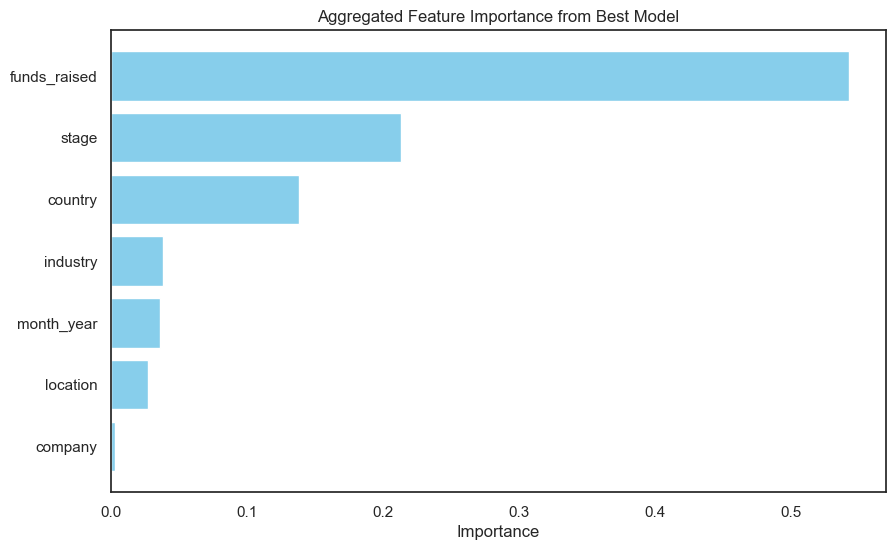

        Feature  Importance
6  funds_raised    0.542985
3         stage    0.213485
4       country    0.138473
2      industry    0.038218
5    month_year    0.036313
1      location    0.027485
0       company    0.003040


In [54]:
# | echo: false

# Extract feature importances from the best pipeline
best_pipeline = mod.best_estimator_

# Get feature names from the preprocessor
def get_feature_names(pipeline):
    preprocessor = pipeline.named_steps['preprocessor']
    feature_names = []

    # Add numeric feature names
    feature_names.extend(numeric_features)  # Assuming numeric_features is defined earlier

    # Add one-hot encoded categorical feature names
    if 'Categorical_processing' in preprocessor.named_transformers_:
        cat_feature_names = preprocessor.named_transformers_['Categorical_processing'].named_steps['OneHotEncoder'].get_feature_names_out(cat_features)
        feature_names.extend(cat_feature_names)

    return feature_names

# Aggregate feature importances
def aggregate_importances(importances, feature_names):
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    aggregated_importance_df = []  # Use a list to collect non-empty DataFrames

    # Sum importances for categorical features
    for cat in cat_features:  # Assuming cat_features is defined earlier
        cat_importances = importance_df[importance_df['Feature'].str.startswith(cat)]
        if not cat_importances.empty:
            total_importance = cat_importances['Importance'].sum()
            importance_df = importance_df[~importance_df['Feature'].str.startswith(cat)]
            new_entry = pd.DataFrame({'Feature': [cat], 'Importance': [total_importance]})

            # Only add new_entry if it's not empty
            if not new_entry.empty:
                aggregated_importance_df.append(new_entry)

    # Convert list of DataFrames to a single DataFrame if not empty
    if aggregated_importance_df:
        aggregated_importance_df = pd.concat(aggregated_importance_df, ignore_index=True)
    else:
        aggregated_importance_df = pd.DataFrame(columns=['Feature', 'Importance'])

    # Concatenate any remaining features that were not aggregated
    return pd.concat([aggregated_importance_df, importance_df], ignore_index=True).sort_values(by='Importance', ascending=False)

# Get feature names and importances
feature_names = get_feature_names(best_pipeline)
regressor = best_pipeline.named_steps['regressor']

# Check for feature importances and plot
if hasattr(regressor, 'feature_importances_'):
    importances = regressor.feature_importances_
    if len(importances) == len(feature_names):
        aggregated_importance_df = aggregate_importances(importances, feature_names)

        # Plot feature importances
        plt.figure(figsize=(10, 6))
        plt.barh(aggregated_importance_df['Feature'], aggregated_importance_df['Importance'], color='skyblue')
        plt.xlabel('Importance')
        plt.title('Aggregated Feature Importance from Best Model')
        plt.gca().invert_yaxis()
        plt.show()

        print(aggregated_importance_df)
    else:
        print("Mismatch in lengths of importances and feature names.")
else:
    print("The selected regressor does not have feature importances.")




Feature importance analysis indicated that funding stage is the most critical predictor of layoffs, followed by the country where the company is located, the industry of the company, the month-year of the layoffs, and the amount of funds raised. The city of the company also contributes marginally, while company title is the least influential predictor.

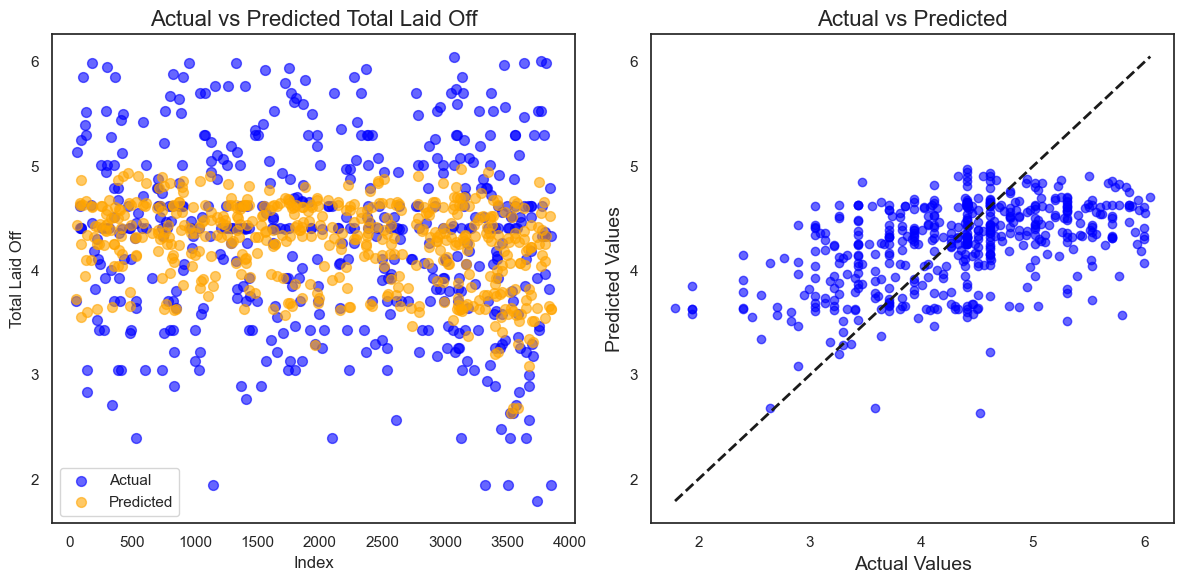

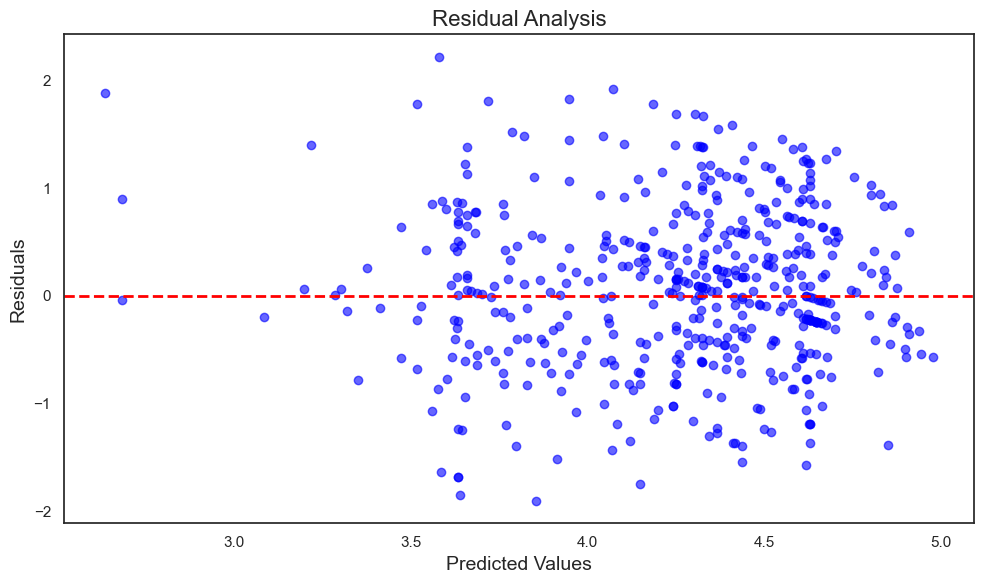

In [55]:
# | echo: false

# plot results

sns.set(style='white')

# Plot Actual vs. Predicted Total Laid Off
plt.figure(figsize=(12, 6))

# Scatter plot for Actual vs Predicted
plt.subplot(1, 2, 1)
plt.scatter(y_test.index, y_test.values, color='blue', alpha=0.6, label='Actual', s=50)
plt.scatter(y_test.index, y_pred, color='orange', alpha=0.6, label='Predicted', s=50)
plt.xlabel('Index')
plt.ylabel('Total Laid Off')
plt.title('Actual vs Predicted Total Laid Off', fontsize=16)
plt.legend()

# Scatter plot for Actual vs Predicted Values
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title("Actual vs Predicted", fontsize=16)
plt.xlabel("Actual Values", fontsize=14)
plt.ylabel("Predicted Values", fontsize=14)

plt.tight_layout()  
plt.show()

# Residual Analysis
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue', alpha=0.6)
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.xlabel('Predicted Values', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residual Analysis', fontsize=16)
plt.tight_layout()
plt.show()


These visualizations illustrate the model's capacity to predict the number of layoffs accurately. While the model is not flawless, as indicated by the Actual vs. Predicted figure, its performance is relatively adequate. The residual analysis shows that the residuals are mostly randomly distributed around zero, suggesting that the model effectively captures the underlying patterns in the data.

## Discussion

The current model is underfitting, as indicated by the training RMSE exceeding the test RMSE. This suggests that it may not be capturing the underlying complexities of the data. To address this, we should explore more sophisticated techniques, particularly neural networks, which excel in modeling nonlinear relationships and feature interactions. Additionally, enhancing feature engineering and applying regularization techniques could help the model learn more effectively while maintaining generalizability. Implementing these strategies may lead to improved predictive accuracy regarding layoffs.